# Resnet50 from lesson 7

In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
%matplotlib inline
import utils3
#reload(utils3)
from utils3 import *
from __future__ import division, print_function

Using Theano backend.


In [4]:
path = "/home/ubuntu/fast-ai/data/dogs-cats-redux/"
model_path = '/home/ubuntu/fast-ai/data/dogs-cats-redux/models/'
batch_size=64
os.path.exists(model_path)

True

In [5]:
import resnet50; reload(resnet50)
from resnet50 import Resnet50

In [6]:
model = Resnet50(include_top=False).model

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [10]:
model.output_shape

(None, 2048, 7, 7)

In [11]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [13]:
trn_features = model.predict_generator(batches, batches.nb_sample)

In [14]:
val_features = model.predict_generator(val_batches, val_batches.nb_sample)

In [15]:
save_array(model_path + 'train_resnet50_features.bc', trn_features)
save_array(model_path + 'valid_resnet50_features.bc', val_features)

In [ ]:
trn_features = load_array(model_path+'train_resnet50_features.bc')
val_features = load_array(model_path+'valid_resnet50_features.bc')

In [16]:
trn_features.shape

(23000, 2048, 7, 7)

In [17]:
def get_fc_layers(p):
    return [
        BatchNormalization(axis=1, input_shape=model.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [18]:
new_model = Sequential(get_fc_layers(.5))

In [19]:
new_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 2048, 7, 7)    8192        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 100352)        0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100352)        0           flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          102761472   dropout_1[0][0]                  
___________________________________________________________________________________________

In [20]:
new_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
new_model.fit(trn_features, trn_labels, nb_epoch=2, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 42s - loss: 0.1134 - acc: 0.9724 - val_loss: 0.0438 - val_acc: 0.9880

## Running on Test Set and Saving Results

In [68]:
import csv
test_batches = get_batches(path + 'test', shuffle=False)
wtr = csv.writer(open (path + 'results/' + 'filenames.csv', 'w'), delimiter=',', lineterminator='\n')
for x in test_batches.filenames : wtr.writerow ([x])

Found 12500 images belonging to 1 classes.


In [69]:
from IPython.display import FileLink
FileLink(path + 'results/' + 'filenames.csv')

/home/ubuntu/fast-ai/data/dogs-cats-redux/results/filenames.csv

In [70]:
resnet_preds = model.predict_generator(test_batches, test_batches.nb_sample)
predicts = new_model.predict(resnet_preds, batch_size=4)

predicts = [x[1] for x in predicts]
predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt(path + 'results/' + 'predicts.csv', predicts, delimiter=',' , fmt='%1.5f')

In [35]:
len(predicts)

12500

In [ ]:
#! /~/fast-ai/scripts/clean_data.sh filenames.csv predicts.csv

In [ ]:
FileLink(path + 'results/' + 'predicts.csv')

In [41]:
def my_predict(imgs, resnet_model, addon_model):
    resnet_preds = resnet_model.predict(imgs)
    all_preds = addon_model.predict(resnet_preds)
    idxs = np.argmax(all_preds, axis=1)
    preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
    return np.array(preds), idxs

In [56]:
batches = get_batches(path+'test/', batch_size=4)

Found 12500 images belonging to 1 classes.


array([ 1.    ,  1.    ,  0.9799,  1.    ], dtype=float32)

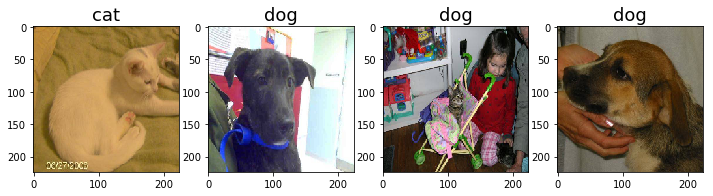

In [67]:
imgs,labels = next(batches)
preds, idxs = my_predict(imgs, model, new_model)
titles = map(lambda idx: ["cat", "dog"][idx], idxs)
plots(imgs, titles=titles)
preds

## Global Avarage Pooling

In [ ]:
def get_ap_layers(p):
    return [
        
    ]